#### Steps:

- read FoR dataset from files (easy)
- preprocess into spectrograms (hard, many decisions)
- batches & epochs (ez, padding?)
- train & val

#### How to preprocess spectrograms?

- Use VGG implementation
- Use tf implementation
- Compare
- Mode = train or eval?
- pad with each batch?

Step 1: check VGG model's preprocessing vs. tf's.

In [1]:
import sys
sys.path.append('../old_code')

In [2]:
# VGG implementation lives in data_prep.py
# not sure how to install librosa on anaconda/windows...
from data_prep import load_data

In [11]:
import os
dirname = "D:/for-norm/training/real"
example = "file1.wav_16k.wav_norm.wav_mono.wav_silence.wav"

example_path = os.path.join(dirname, example)

os.path.exists(example_path), example_path

(True,
 'D:/for-norm/training/real\\file1.wav_16k.wav_norm.wav_mono.wav_silence.wav')

In [8]:
features = load_data(example_path, mode='train')
features.shape

(257, 250)

In [9]:
features

array([[-0.35775694, -0.3200838 , -0.3540595 , ..., -0.28211892,
        -0.27432853, -0.4232404 ],
       [-0.34415048, -0.33131132, -0.3436555 , ..., -0.31520504,
        -0.28600565, -0.41195664],
       [-0.33139658, -0.3164042 , -0.34123638, ..., -0.13743632,
        -0.30408368, -0.40212035],
       ...,
       [-0.36088   , -0.3405289 , -0.36287412, ..., -0.43080318,
        -0.43631625, -0.45777506],
       [-0.36081228, -0.34052598, -0.36290178, ..., -0.43055034,
        -0.4361343 , -0.45764092],
       [-0.36084488, -0.340551  , -0.36287117, ..., -0.4302919 ,
        -0.43593714, -0.45756805]], dtype=float32)

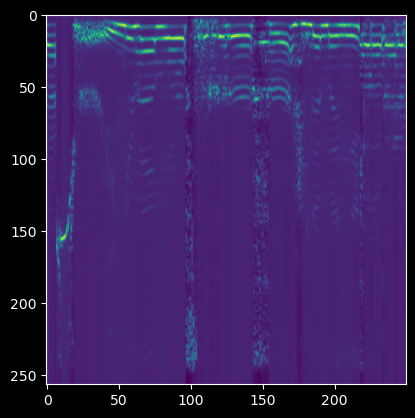

In [10]:
import matplotlib.pyplot as plt
plt.style.use('dark_background')
plt.imshow(features)

In [14]:
def vgg_prep(path="D:/for-norm/training/real\\file1.wav_16k.wav_norm.wav_mono.wav_silence.wav", mode="train"):
    features = load_data(example_path, mode=mode)
    plt.imshow(features)

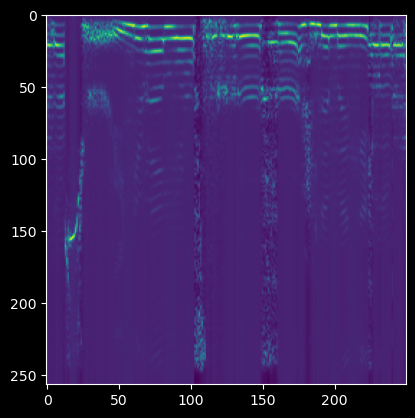

In [17]:
vgg_prep(mode='train')

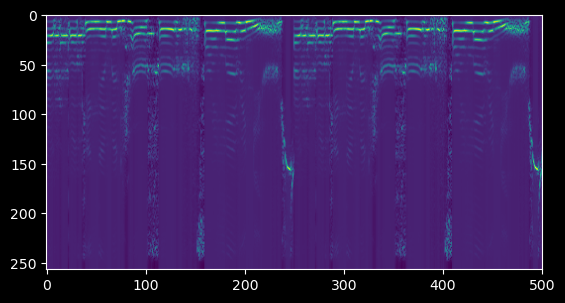

In [16]:
vgg_prep(mode='eval')